# Import Packages

In [59]:
# import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np

# Import data

In [60]:
# Import Raw Data
adata = sc.read_h5ad('/home/glennrossdolan/Documents/gut-signaling-jakstat-ibd/06_data_repository/02_Pediatric_CD/norm_pediatric_chron_ileum.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 22502 × 26657
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state'
    var: 'gene_ids-4918STDY7273964', 'gene_ids-4918STDY7273965', 'gene_ids-4918STDY7274839', 'gene_ids-4918STDY7317586', 'gene_ids-4918STDY7321514', 'gene_ids-4918STDY7333456', 'gene_ids-4918STDY7389431', 'gene_ids-4918STDY7421298', 'gene_ids-4918STDY7426905', 'gene_ids-4918STDY7426908', 'gene_ids-4918STDY7447825', 'gene_ids-4918STDY7693758', 'gene_ids-4918STDY7693761', 'gene_ids-4918STDY7702679', 'gene_ids-4918STDY7702680', 'gene_ids-4918STDY7717784', 'gene_ids-4918STDY7717788', 'gene_ids-4918STDY7718973', 'gene_ids-4918STDY7718976', 'gene_ids-4918STDY7844898', 'gene_ids-4918STDY7844899', 'gene_ids-4918STDY7901095', 'gene_ids-4918STDY7901096', 'gene_ids-4918STDY7923744', 'gene_ids-4918STDY7923745', 'gene_ids-4918STDY7933270', 'gene_ids-4918STDY7934977', 'gene_ids-

# Data Cleaning

In [61]:
# Create a dictionary for mapping old names to new names
rename_dict = {
    "CD": "Crohn_Inflamed", 
    "Control": "Control", 
    "non_inflamed": "Crohn_Uninflamed"
}

# Apply the renaming
adata.obs["inferred state"] = adata.obs["inferred state"].map(rename_dict)

In [62]:
# Direct mapping from sample IDs to your desired naming scheme
sample_mapping = {
    "T024": "Control_1",
    "T036": "Control_2",
    "T44": "Control_3",
    "T057": "Control_4",
    "T110": "Control_5",
    "T160": "Control_6",
    "T161": "Control_7",
    "T182": "Control_8",
    "T017": "Crohn_Inflamed_1",
    "T019": "Crohn_Inflamed_2",
    "T176": "Crohn_Inflamed_3",
    "T189": "Crohn_Inflamed_4",
    "T203": "Crohn_Inflamed_5",
    "T197": "Crohn_Uninflamed_1",
    "T202": "Crohn_Uninflamed_2"
}

# Apply the mapping directly
adata.obs["Sample name"] = adata.obs["Sample name"].map(sample_mapping)

In [63]:
# Reorder samples
new_order = ['Control_1', 'Control_2', 'Control_3', 'Control_4', 'Control_5', 'Control_6', 'Control_7', 'Control_8', 'Crohn_Uninflamed_1', 'Crohn_Uninflamed_2', 'Crohn_Inflamed_1', 'Crohn_Inflamed_2', 'Crohn_Inflamed_3', 'Crohn_Inflamed_4', 'Crohn_Inflamed_5']

adata.obs['Sample name'] = adata.obs['Sample name'].cat.reorder_categories(new_order, ordered=True)

In [64]:
# Reorder states
new_order = ['Control', 'Crohn_Uninflamed', 'Crohn_Inflamed']

adata.obs['inferred state'] = adata.obs['inferred state'].cat.reorder_categories(new_order, ordered=True)

# Change colour palette
custom_palette = ['#2dc937', '#f2ce1b', '#cc3232']

adata.uns['inferred state_colors'] = custom_palette

# Personalised Functions

In [65]:
def plot_umap(
    adata, 
    annotation_key='annotation_V2',
    palette="hls",
    palette_num=None,
    figsize=9,
    s=15,
    bg_color='#f0f0f0',
    fontsize=10,
    title_fontsize=12,
    title=None
):
    """
    Plot UMAP visualization of single-cell data with customizable options.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object containing UMAP coordinates in .obsm['X_umap']
    annotation_key : str, default='annotation_V2'
        Key in adata.obs for cell annotations/clusters
    palette : str or list, default='hls'
        Color palette name or list of colors
    palette_num : int, optional
        Number of colors in the palette. If None, uses number of unique annotations
    figsize : int, default=9
        Size of the square figure
    s : int, default=15
        Size of scatter points
    bg_color : str, default='#f0f0f0'
        Background color of the plot
    fontsize : int, default=10
        Font size for legend text
    title_fontsize : int, default=12
        Font size for legend title and plot title
    title : str, optional
        Title for the plot. If None, no title is displayed
        
    Returns
    -------
    matplotlib.figure.Figure, matplotlib.axes.Axes
        Figure and axes objects for further customization
    """
    # Extract UMAP coordinates and annotations
    umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
    umap_df[annotation_key] = adata.obs[annotation_key].values
    
    # Get unique categories
    categories = umap_df[annotation_key].unique()
    
    # Set palette_num if not provided
    if palette_num is None:
        palette_num = len(categories)
    
    # Create color palette
    colors = sns.color_palette(palette, palette_num)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    
    # Set background color
    ax.set_facecolor(bg_color)
    
    # Create scatter plot
    sns.scatterplot(
        x='UMAP1', y='UMAP2',
        hue=annotation_key,
        data=umap_df,
        palette=colors,
        s=s,
        ax=ax,
        edgecolor=None,
        linewidth=0,
    )
    
    # Ensure grid is below the scatterplot
    ax.set_axisbelow(True)
    
    # Add grid lines
    ax.grid(True, color='white', linewidth=2, alpha=0.7)
    
    # Create square patches for the legend
    handles = []
    for color, label in zip(colors, categories):
        patch = mpatches.Patch(color=color, label=label)
        handles.append(patch)
    
    # Add custom legend with square keys
    ax.legend(
        handles=handles,
        title=annotation_key,
        fontsize=fontsize,
        title_fontsize=title_fontsize,
        loc='best',
        frameon=False,
        handleheight=1.5,
        handlelength=1.5
    )
    
    # Add title if provided
    if title:
        ax.set_title(title, fontsize=title_fontsize)
    
    return fig, ax

# Example usage:
# fig, ax = plot_umap(
#     epith_adata,
#     annotation_key='annotation_V2',
#     palette='hls',
#     palette_num=10,
#     figsize=9,
#     s=15,
#     bg_color='#f0f0f0',
#     fontsize=10,
#     title_fontsize=12,
#     title='UMAP of Epithelial Cells'
# )
# plt.show()

# Create Cell Type Groups

                                   annotation_V2  cell_group
index                                                       
AAACGGGTCATAGCAC-1-4918STDY7273964    CD4 T cell      Immune
AAAGATGAGTCCAGGA-1-4918STDY7273964            TA  Epithelium
AAAGATGCAAGCCCAC-1-4918STDY7273964    CD4 T cell      Immune
AAAGATGTCAGTCAGT-1-4918STDY7273964    CD4 T cell      Immune
AAAGATGTCTAACTTC-1-4918STDY7273964            TA  Epithelium


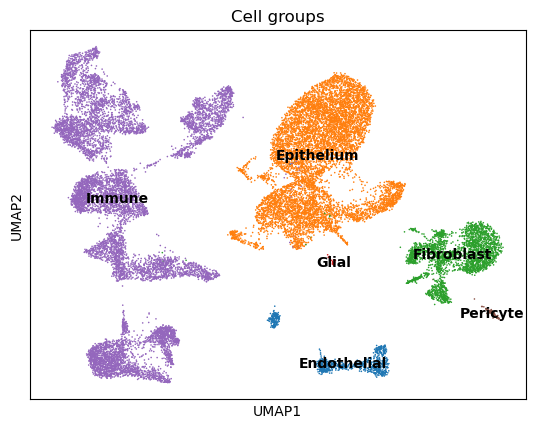

In [66]:
# Define dictionary mapping cell types to cell groups
cell_type_to_group = {
    # Epithelium (yellow)
    'crypt': 'Epithelium',
    'TA': 'Epithelium',
    'early enterocyte': 'Epithelium',
    'enterocyte': 'Epithelium',
    'enteroendocrine': 'Epithelium',
    'BEST4 enterocyte': 'Epithelium',
    'Goblet cell': 'Epithelium',
    'IL2RG+ enterocyte (M cell)': 'Epithelium',
    'Paneth cell': 'Epithelium',
    'Tuft': 'Epithelium',
    
    # Fibroblast (red)
    'S1 fibroblasts': 'Fibroblast',
    'S2 fibroblasts': 'Fibroblast',
    'S4 fibroblasts': 'Fibroblast',
    'myofibroblast': 'Fibroblast',
    
    # Glial (purple)
    'Glial cell': 'Glial',
    
    # Pericyte (orange)
    'pericyte': 'Pericyte',
    
    # Endothelial (green)
    'Arterial endothelial cell': 'Endothelial',
    'Venous endothelial cell': 'Endothelial',
    'Lymphatic endothelial cell': 'Endothelial',
    
    # Immune (blue)
    'B cell': 'Immune',
    'FCER2 B cell': 'Immune',
    'Memory B cell': 'Immune',
    'Activated B cell': 'Immune',
    'Cycling B cell': 'Immune',
    'Cycling plasma cell': 'Immune',
    'IgA plasma cell': 'Immune',
    'IgG plasma cell': 'Immune',
    'CD8 T cell': 'Immune',
    'CD4 T cell': 'Immune',
    'Tfh': 'Immune',
    'Activated T': 'Immune',
    'Treg': 'Immune',
    'gd T/NK cell': 'Immune',
    'mast cells': 'Immune',
    'Monocyte': 'Immune',
    'Cycling myeloid cells': 'Immune',
    'Macrophage': 'Immune',
    'cDC1': 'Immune',
    'cDC2': 'Immune',
    'activated DC': 'Immune',
    'pDC': 'Immune'
}

# Add the new column to the AnnData object
adata.obs['cell_group'] = adata.obs['annotation_V2'].map(cell_type_to_group)

# Check if any cell types were not mapped
missing_cell_types = set(adata.obs['annotation_V2'].unique()) - set(cell_type_to_group.keys())
if missing_cell_types:
    print(f"Warning: The following cell types were not mapped to any group: {missing_cell_types}")
    
# Display first few rows to verify the new annotation
print(adata.obs[['annotation_V2', 'cell_group']].head())

# Optional: Create a categorical type for the cell_group column
adata.obs['cell_group'] = adata.obs['cell_group'].astype('category')

# Optional: Plot the new groups
try:
    import scanpy as sc
    sc.pl.umap(adata, color='cell_group', legend_loc='on data', title='Cell groups')
except Exception as e:
    print(f"Could not create plot: {e}")

# Visualising the data

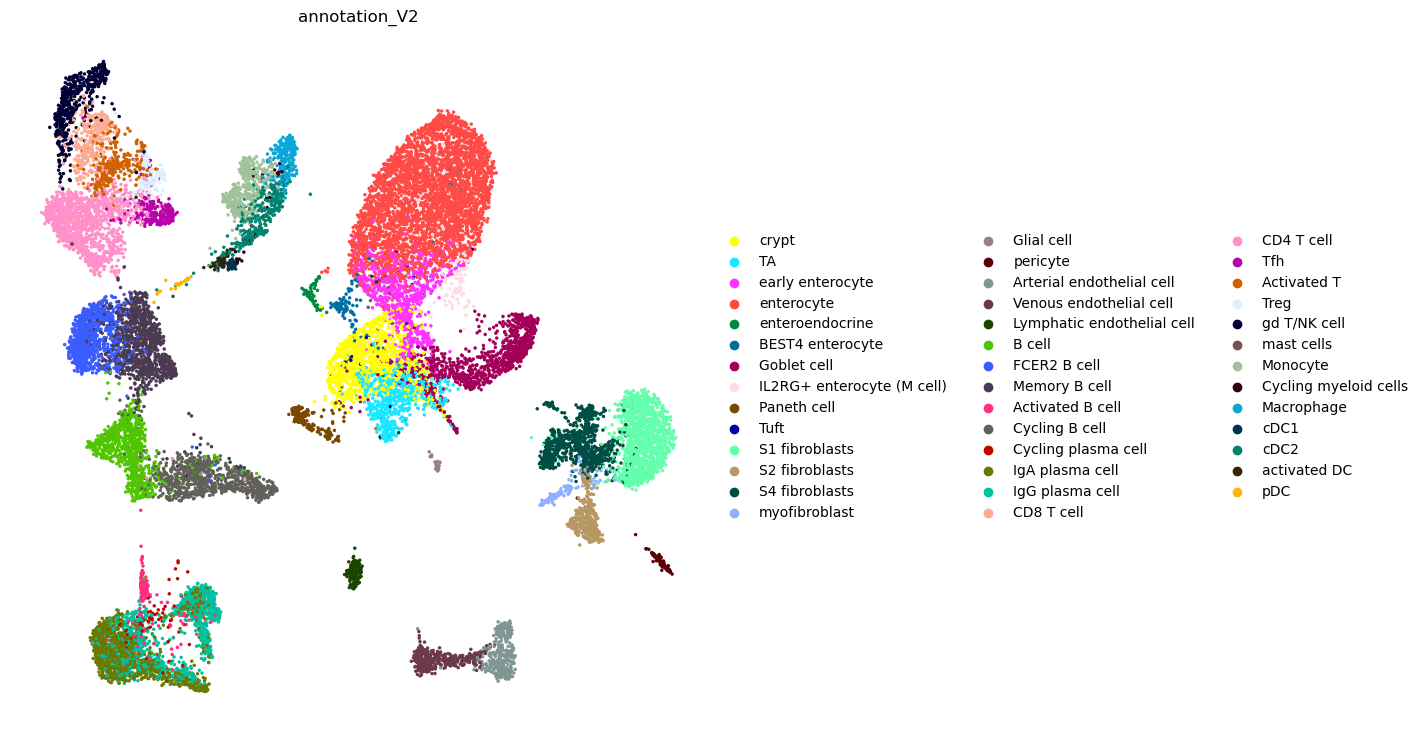

In [67]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["annotation_V2"],
    frameon=False,
    size=25,
    ax=ax
)

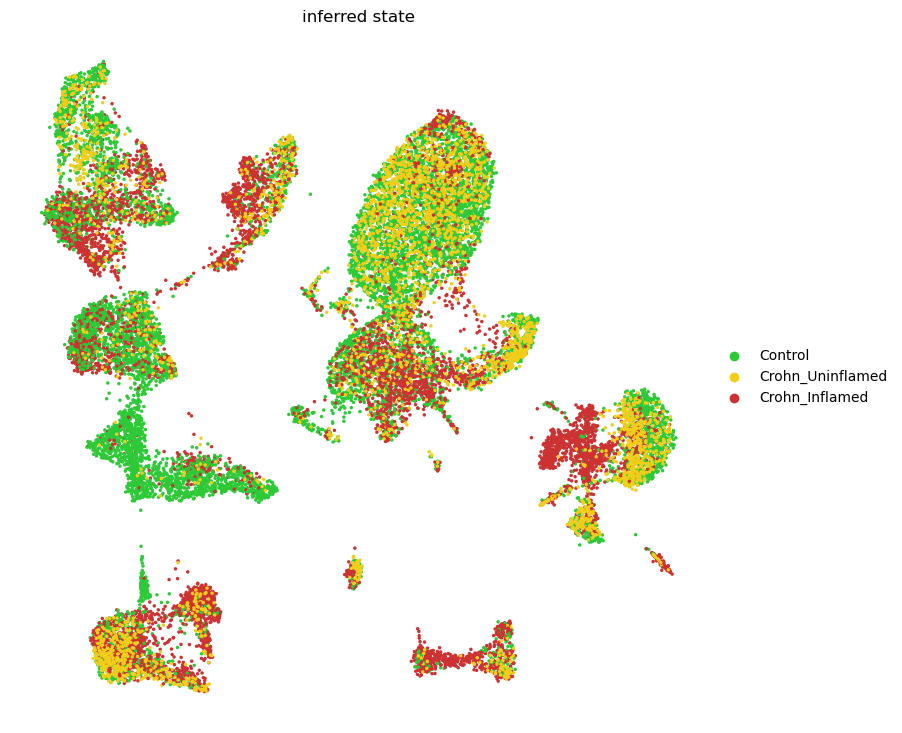

In [68]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["inferred state"],
    frameon=False,
    size=25,
    ax=ax
)

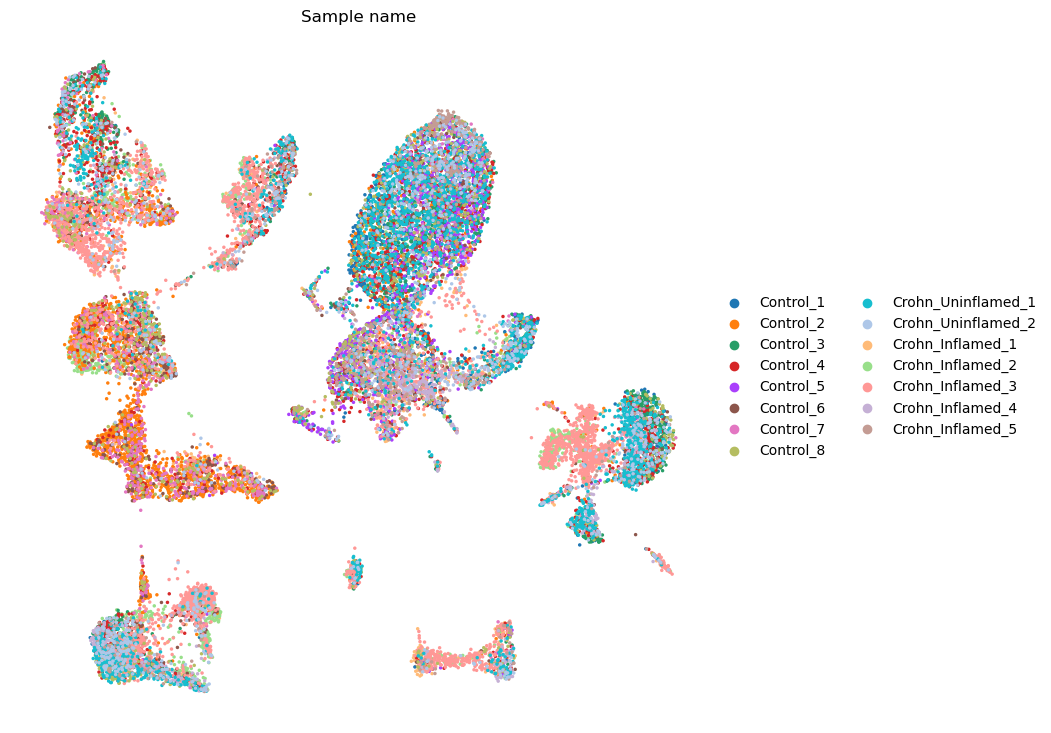

In [69]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    adata,
    color=["Sample name"],
    frameon=False,
    size=25,
    ax=ax
)

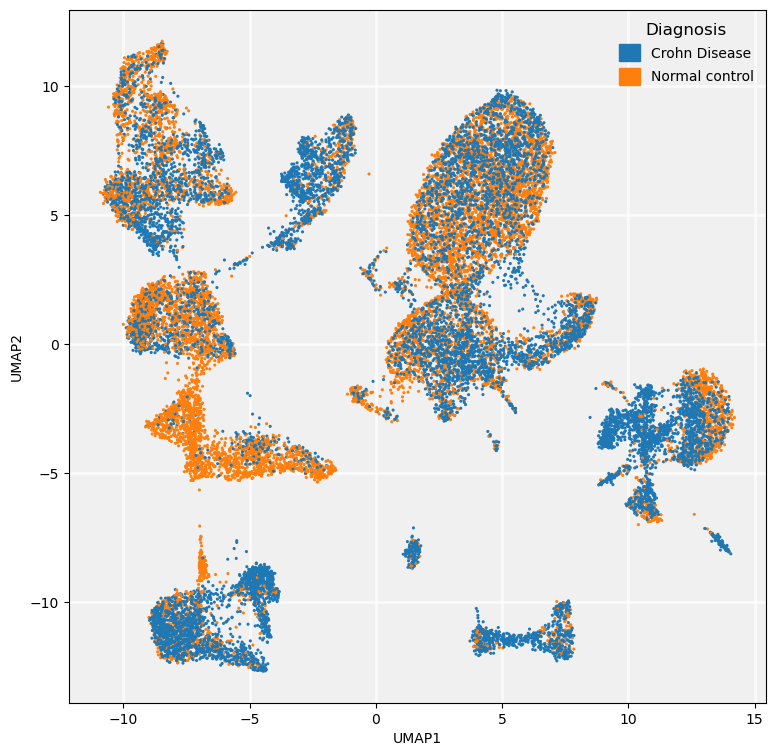

In [70]:
# Get UMAP coordinates and metadata
umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
umap_df['Diagnosis'] = adata.obs['Diagnosis'].values

# Create the plot
fig, ax = plt.subplots(figsize=(9, 9))

# Set background colors
ax.set_facecolor('#f0f0f0')

# Scatter plot with seaborn
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    hue='Diagnosis', 
    data=umap_df,
    palette='tab10',
    s=5,
    ax=ax,
    edgecolor=None,  # No outline
    linewidth=0,      # Also make sure no border width
    
)

ax.set_axisbelow(True)

# Add grid
ax.grid(True, color='white', linewidth=2, alpha=0.7)

# ✅ Create square patches for legend
handles = []
palette = sns.color_palette('tab10', n_colors=umap_df['Diagnosis'].nunique())
for color, label in zip(palette, umap_df['Diagnosis'].unique()):
    patch = mpatches.Patch(color=color, label=label)
    handles.append(patch)

# ✅ Add legend with square keys
ax.legend(
    handles=handles, 
    title='Diagnosis', 
    fontsize=10, 
    title_fontsize=12, 
    loc='best',
    frameon=False,
    handleheight=1.5,  # Make the handle height larger
    handlelength=1.5   # Make handle length same as height => square!
)



plt.show()



In [71]:
epith_adata = adata[adata.obs['cell_group'] == 'Epithelium'].copy()
immun_adata = adata[adata.obs['cell_group'] == 'Immune'].copy()

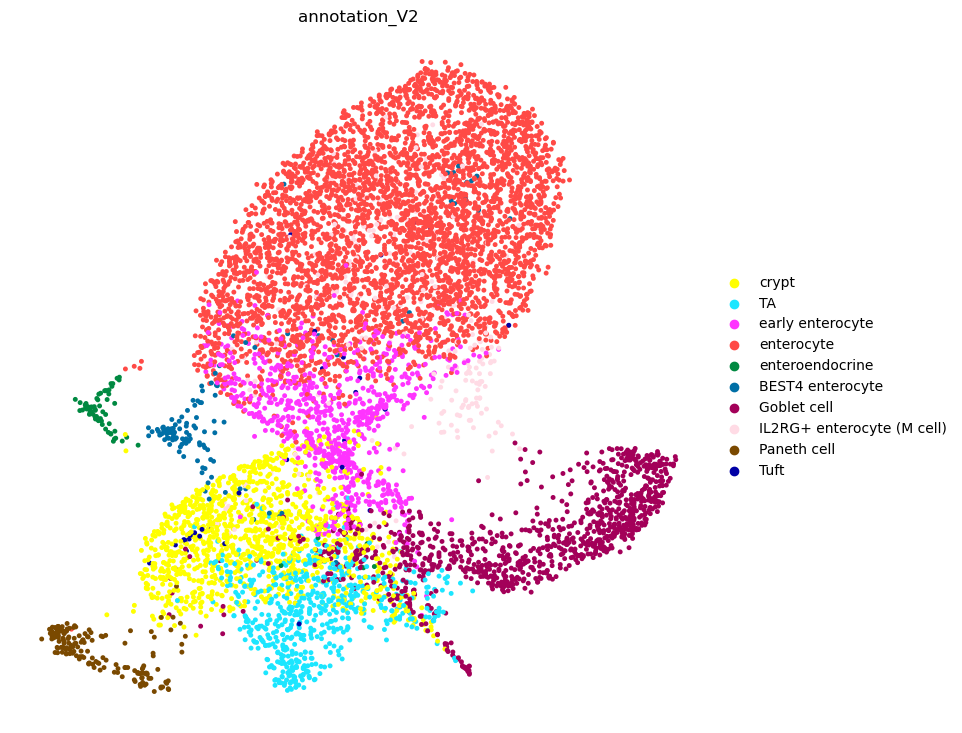

In [72]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    epith_adata,
    color=["annotation_V2"],
    frameon=False,
    size=50,
    ax=ax
)

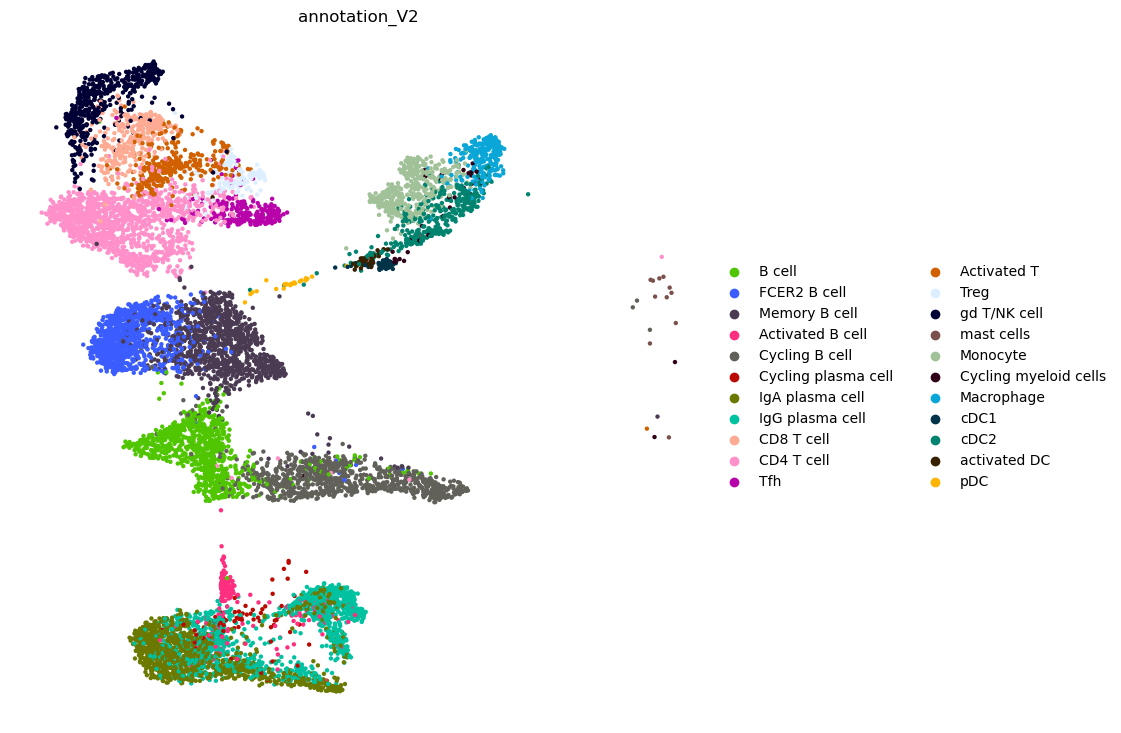

In [73]:
# Plot the UMAP
fig, ax = plt.subplots(figsize=(9, 9))  # Adjust the figsize values as needed

# Plot UMAP on the specified axis
sc.pl.umap(
    immun_adata,
    color=["annotation_V2"],
    frameon=False,
    size=40,
    ax=ax
)

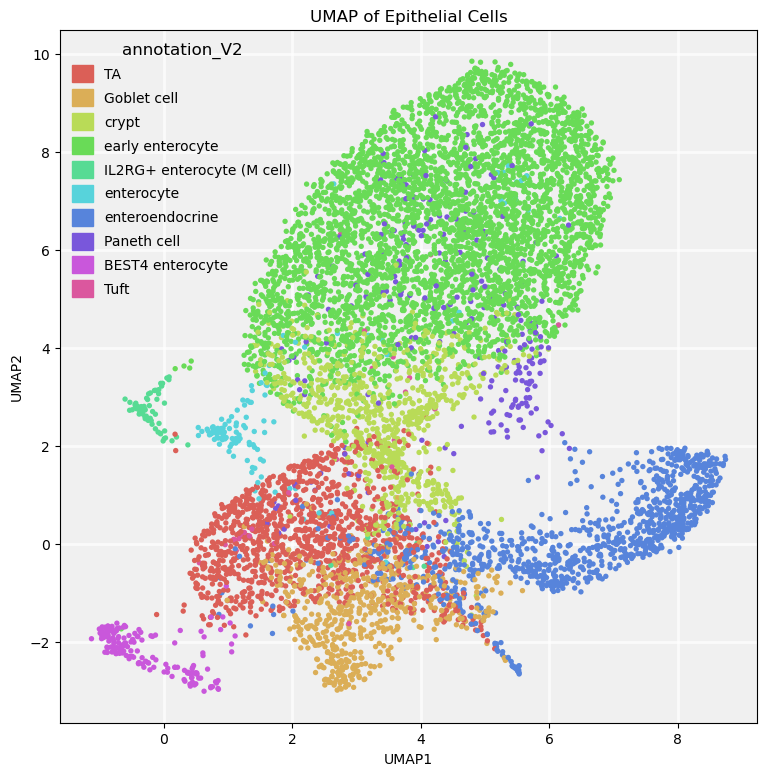

In [74]:
fig, ax = plot_umap(
    epith_adata,
    annotation_key='annotation_V2',
    palette='hls',
    figsize=9,
    s=15,
    bg_color='#f0f0f0',
    fontsize=10,
    title_fontsize=12,
    title='UMAP of Epithelial Cells'
)
plt.show()

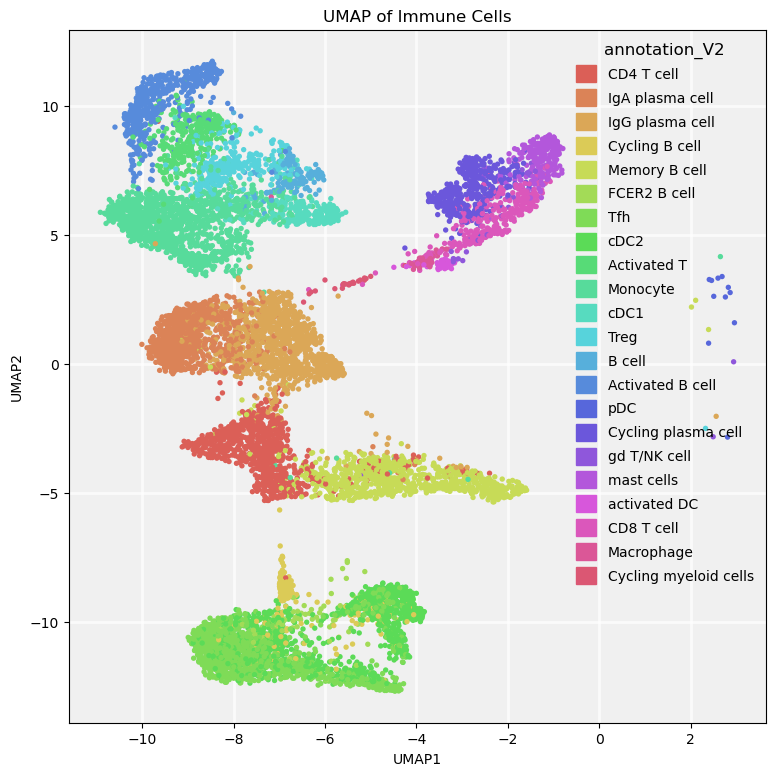

In [75]:
fig, ax = plot_umap(
    immun_adata,
    annotation_key='annotation_V2',
    palette='hls',
    figsize=9,
    s=15,
    bg_color='#f0f0f0',
    fontsize=10,
    title_fontsize=12,
    title='UMAP of Immune Cells'
)
plt.show()

# Plot Expression of genes on UMAP

In [76]:
# List your keywords (make them lowercase for case-insensitive search)
keywords = ["socs"]

# Find genes where any keyword appears
matching_genes = [gene for gene in adata.var_names if any(k in gene.lower() for k in keywords)]

print(f"Found {len(matching_genes)} matching genes:")
print(matching_genes)

Found 7 matching genes:
['SOCS5', 'SOCS2', 'SOCS4', 'SOCS1', 'SOCS7', 'SOCS3', 'SOCS6']


In [77]:
import matplotlib.pyplot as plt
import scanpy as sc

def plot_gene_heatmap_umap_by_state_epithelium(adata, genes, state_column='inferred state', cell_group = '', size=30):
    """
    Plot heatmap UMAPs for a list of genes in an AnnData object, filtered for certain cells only,
    separated by disease state.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the single-cell data.
    genes : list
        A list of gene names to plot.
    state_column : str
        Column name in adata.obs containing the state information.
    size : int
        Size of the dots in the UMAP plot.
        
    Returns:
    --------
    None. The function displays the plots.
    """
    # Filter the data to include only epithelium cells
    filtered_adata = adata[adata.obs['cell_group'] == cell_group].copy()
    
    # Check if any epithelium cells are present
    if filtered_adata.n_obs == 0:
        print("No cells found in the dataset.")
        return
    
    print(f"Analyzing {filtered_adata.n_obs} cells")
    
    # Get unique states
    states = filtered_adata.obs[state_column].cat.categories.tolist()
    num_genes = len(genes)
    num_states = len(states)
    
    # Create a grid of plots: states as rows, genes as columns
    fig, axes = plt.subplots(num_states, num_genes,
                            figsize=(5*num_genes, 5*num_states),
                            squeeze=False)
    
    # For each state, create a subset of the data
    for i, state in enumerate(states):
        state_adata = filtered_adata[filtered_adata.obs[state_column] == state].copy()
        
        # Check if any cells exist for this state
        if state_adata.n_obs == 0:
            print(f"No cells found for state: {state}")
            continue
            
        # Plot each gene for this state
        for j, gene in enumerate(genes):
            ax = axes[i, j]
            
            # Title for the first row only (gene names)
            if i == 0:
                title = f'{gene}'
            else:
                title = ''
                
            # Add state label on the left side
            if j == 0:
                ax.set_ylabel(state, fontsize=14, fontweight='bold')
                
            # Check if gene exists in the dataset
            if gene not in state_adata.var_names:
                print(f"Gene {gene} not found in the dataset")
                ax.text(0.5, 0.5, f"{gene} not found", 
                        ha='center', va='center', transform=ax.transAxes)
                ax.set_facecolor('lightgray')
                continue
                
            sc.pl.umap(
                state_adata,
                color=gene,
                title=title,
                frameon=False,
                ax=ax,
                size=size,
                vmin=-1,
                vmax=2,
                color_map='rainbow',
                legend_loc = 'none',
                show=False
            )
            ax.set_facecolor('black')
            
            # Remove axis labels except for the leftmost column and bottom row
            if j > 0:
                ax.set_ylabel('')
            if i < num_states - 1:
                ax.set_xlabel('')
                
    plt.tight_layout()
    plt.show()

# Example usage:
# First make sure you have the cell_group column in your adata object
# Then run:
# plot_gene_heatmap_umap_by_state_epithelium(adata,
#     ['JAK1', 'JAK2', 'STAT1', 'STAT2', 'SOCS1'],
#     state_column='inferred state',
#     size=20)

Analyzing 10224 cells


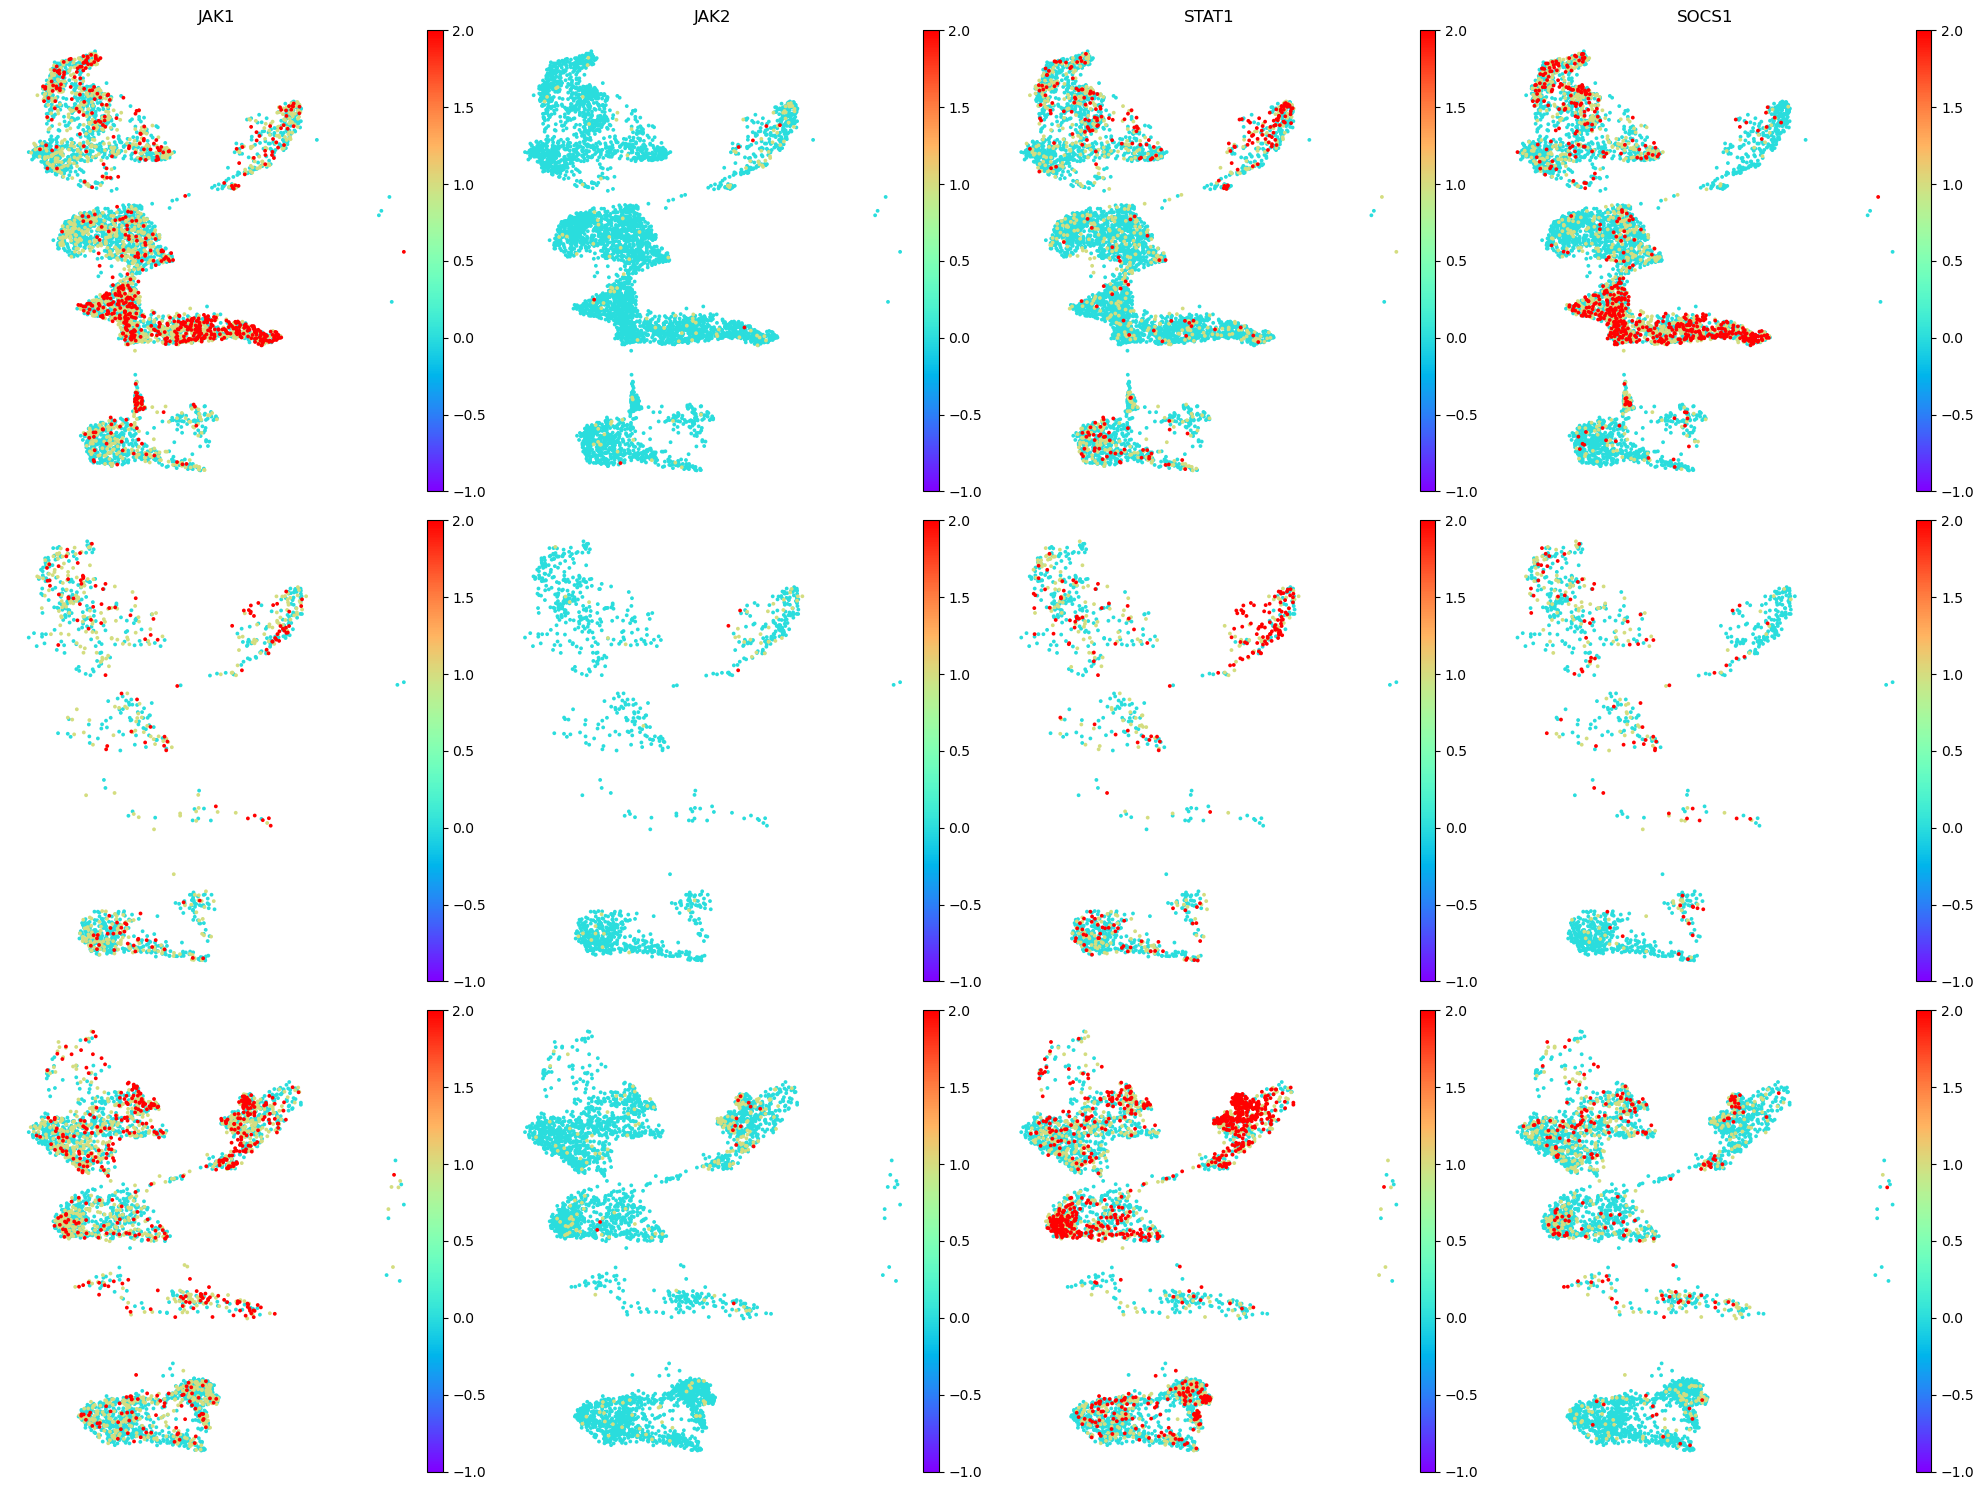

In [78]:
plot_gene_heatmap_umap_by_state_epithelium(adata,
    ['JAK1', 'JAK2', 'STAT1', 'SOCS1'],
    state_column='inferred state',
    cell_group = 'Immune',
    size=30)

Analyzing 8426 cells


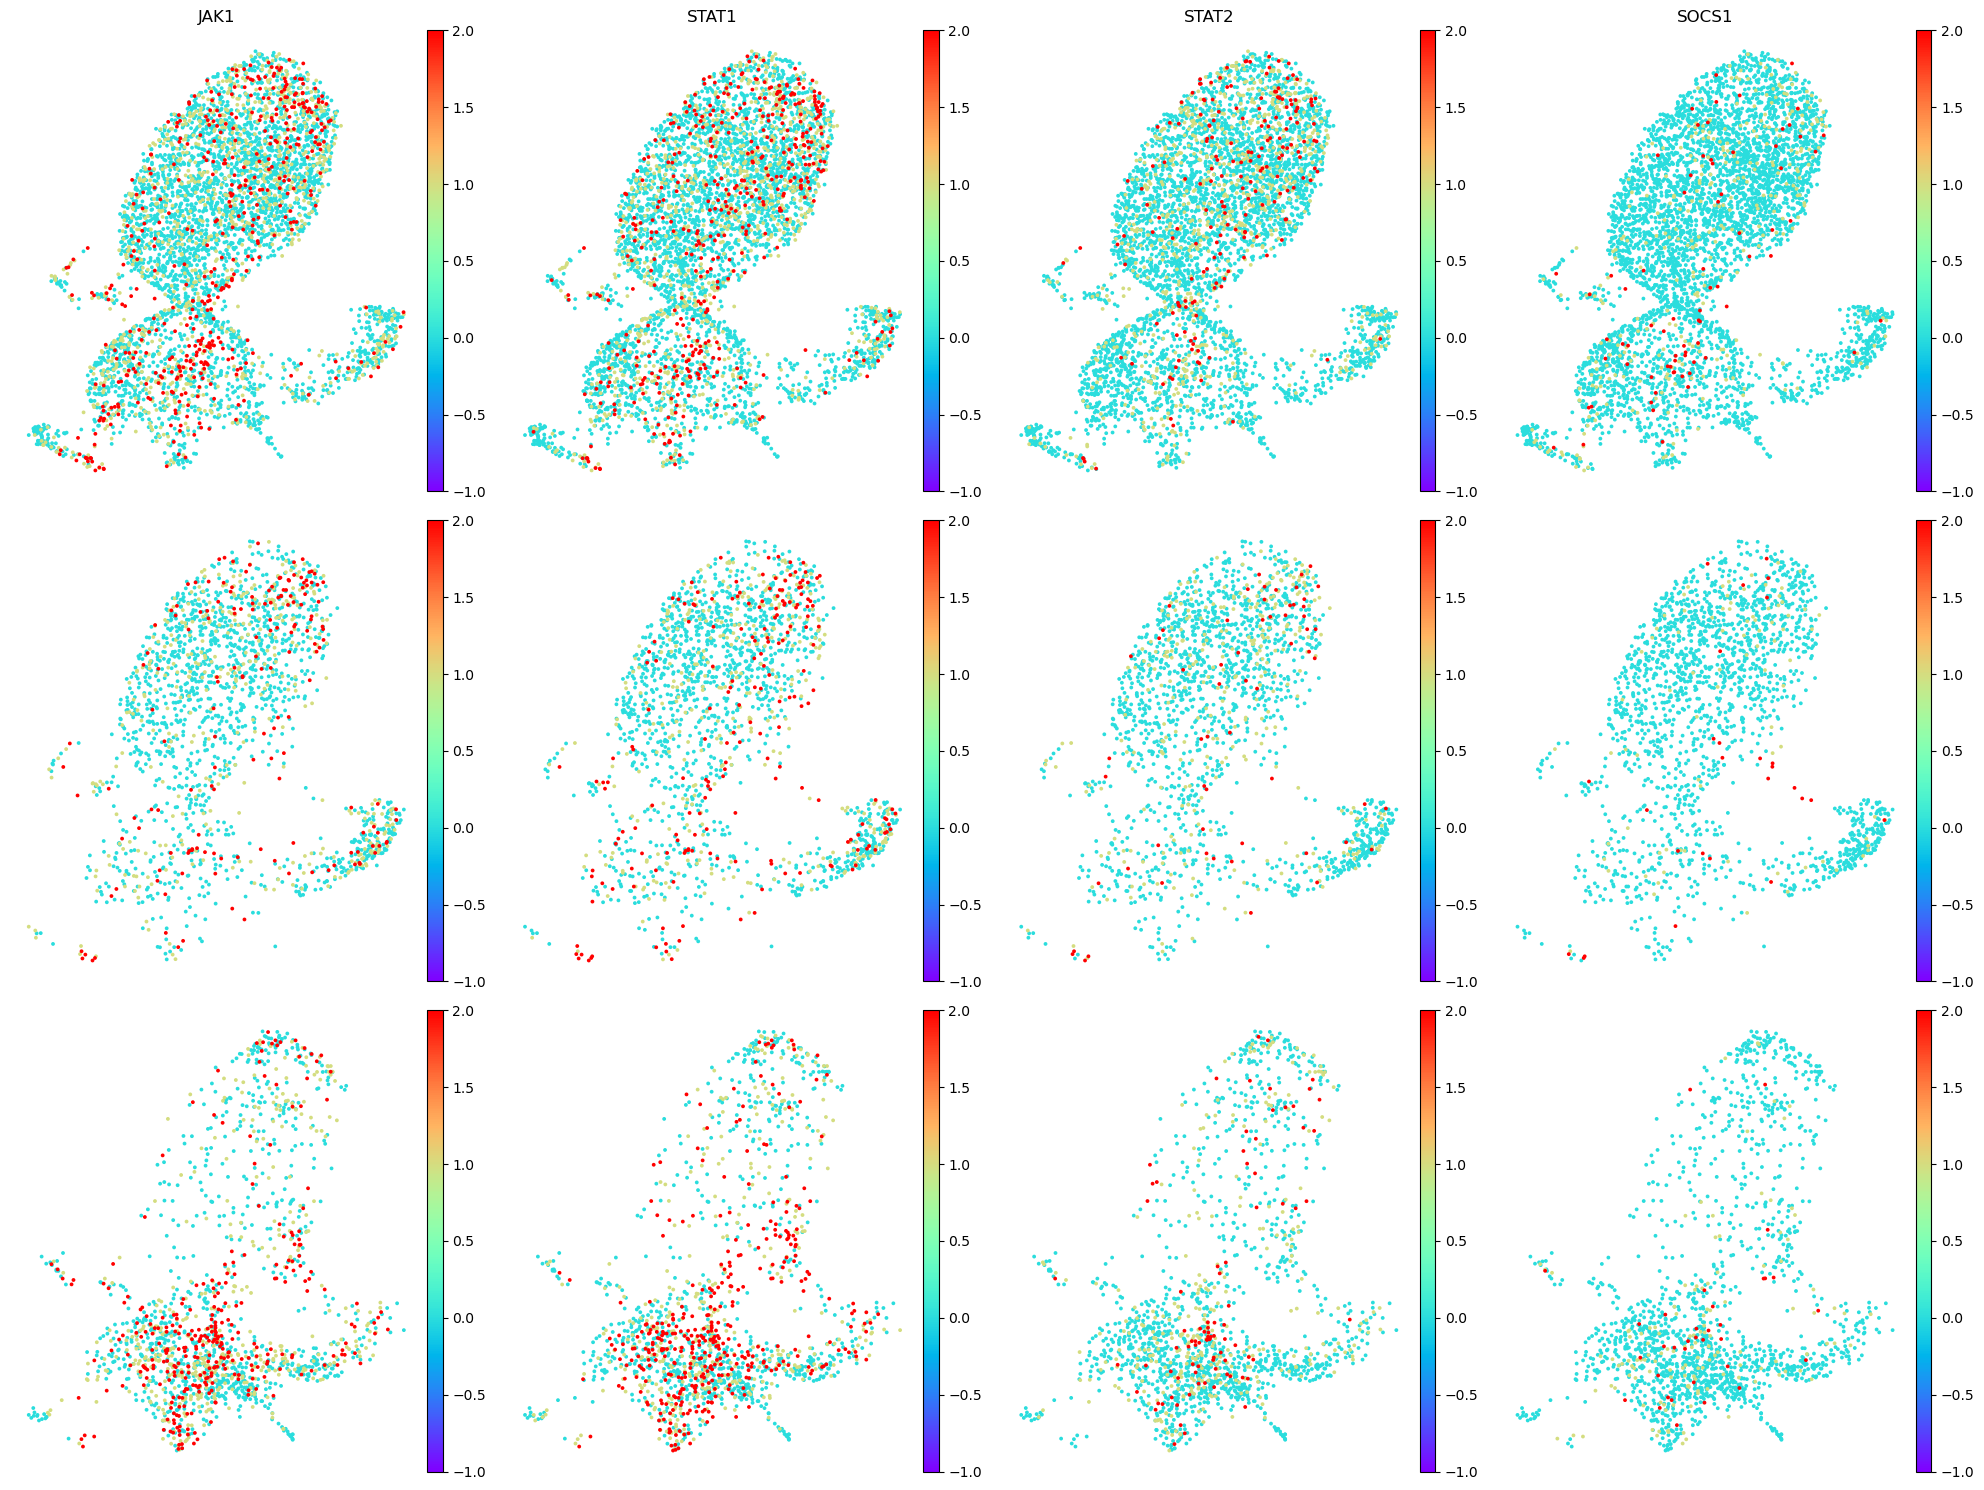

In [79]:
plot_gene_heatmap_umap_by_state_epithelium(adata,
    ['JAK1', 'STAT1', 'STAT2', 'SOCS1'],
    state_column='inferred state',
    cell_group = 'Epithelium',
    size=30)

In [80]:
# Count number of cells per inferred state
for state in adata.obs['inferred state'].unique():
    filt_adata = adata[adata.obs['inferred state'] == state].copy()
    print(state)
    print(filt_adata)

Crohn_Inflamed
AnnData object with n_obs × n_vars = 7521 × 26657
    obs: 'Age', 'Diagnosis', 'Sample name', 'Type', 'batch', 'doublet_scores', 'predicted_doublets', 'n_genes', 'percent_mito', 'n_counts', 'annotation_V2', 'inferred state', 'cell_group'
    var: 'gene_ids-4918STDY7273964', 'gene_ids-4918STDY7273965', 'gene_ids-4918STDY7274839', 'gene_ids-4918STDY7317586', 'gene_ids-4918STDY7321514', 'gene_ids-4918STDY7333456', 'gene_ids-4918STDY7389431', 'gene_ids-4918STDY7421298', 'gene_ids-4918STDY7426905', 'gene_ids-4918STDY7426908', 'gene_ids-4918STDY7447825', 'gene_ids-4918STDY7693758', 'gene_ids-4918STDY7693761', 'gene_ids-4918STDY7702679', 'gene_ids-4918STDY7702680', 'gene_ids-4918STDY7717784', 'gene_ids-4918STDY7717788', 'gene_ids-4918STDY7718973', 'gene_ids-4918STDY7718976', 'gene_ids-4918STDY7844898', 'gene_ids-4918STDY7844899', 'gene_ids-4918STDY7901095', 'gene_ids-4918STDY7901096', 'gene_ids-4918STDY7923744', 'gene_ids-4918STDY7923745', 'gene_ids-4918STDY7933270', 'gene_ids-

# Test

In [122]:
def plot_gene_expression_by_state(
    adata,
    gene_id,
    state_key='inferred_state',
    figsize=9,
    s=15,
    bg_color='#f0f0f0',
    fontsize=10,
    title_fontsize=12,
    cmap='viridis',
    use_raw=True,
    log_transform=False,
    vmin=-1,
    vmax=1,
    state_order=None  # NEW PARAMETER for custom state order
):
    """
    Plot separate UMAP visualizations for each inferred state, 
    showing gene expression in each state.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object containing UMAP coordinates in .obsm['X_umap']
    gene_id : str
        Gene identifier to plot expression for
    state_key : str, default='inferred_state'
        Key in adata.obs for cell state annotations
    figsize : int, default=9
        Size of each individual plot
    s : int, default=15
        Size of scatter points
    bg_color : str, default='#f0f0f0'
        Background color of the plot
    fontsize : int, default=10
        Font size for axis labels and colorbar
    title_fontsize : int, default=12
        Font size for plot titles
    cmap : str, default='viridis'
        Colormap for gene expression
    use_raw : bool, default=True
        Whether to use adata.raw for gene expression
    log_transform : bool, default=False
        Whether to log-transform expression values
    vmin : float, optional
        Minimum value for color scale (if None, will be set automatically)
    vmax : float, optional
        Maximum value for color scale (if None, will be set automatically)
    state_order : list, optional
        Custom order of states to plot. If None, uses the order from adata.obs[state_key].unique()
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure with subplots for each state
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    from matplotlib.colors import Normalize
    
    # Check if the state_key exists in adata.obs
    if state_key not in adata.obs:
        raise ValueError(f"State key '{state_key}' not found in adata.obs")
    
    # Get unique states
    if state_order is None:
        states = adata.obs[state_key].unique().tolist()
    else:
        # Validate that all provided states exist in the data
        available_states = set(adata.obs[state_key].unique())
        for state in state_order:
            if state not in available_states:
                raise ValueError(f"State '{state}' in state_order not found in adata.obs['{state_key}']")
        states = state_order
    
    # Extract UMAP coordinates
    umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
    
    # Add state information
    umap_df[state_key] = adata.obs[state_key].values
    
    # Get gene expression
    if use_raw and adata.raw is not None:
        if gene_id in adata.raw.var_names:
            gene_expr = adata.raw[:, gene_id].X
        else:
            raise ValueError(f"Gene {gene_id} not found in adata.raw.var_names")
    else:
        if gene_id in adata.var_names:
            gene_expr = adata[:, gene_id].X
        else:
            raise ValueError(f"Gene {gene_id} not found in adata.var_names")
    
    # Convert sparse matrix to dense if needed
    if hasattr(gene_expr, "toarray"):
        gene_expr = gene_expr.toarray()
    
    # Flatten if needed
    if gene_expr.ndim > 1:
        gene_expr = gene_expr.flatten()
    
    # Apply log transform if specified
    if log_transform:
        # Add small value to avoid log(0)
        gene_expr = np.log1p(gene_expr)
    
    # Add gene expression to the dataframe
    umap_df['gene_expression'] = gene_expr
    
    # Set vmin and vmax if not provided
    if vmin is None:
        vmin = umap_df['gene_expression'].min()
    if vmax is None:
        vmax = umap_df['gene_expression'].max()
    
    # Create subplots - one for each state with minimal spacing
    n_states = len(states)
    fig, axes = plt.subplots(1, n_states, figsize=(figsize * n_states, figsize), 
                            gridspec_kw={'wspace': 0.02})  # Minimal spacing between plots
    
    # Handle the case with a single state
    if n_states == 1:
        axes = [axes]
    
    # Plot each state
    for i, state in enumerate(states):
        ax = axes[i]
        
        # Filter for this state
        state_data = umap_df[umap_df[state_key] == state]
        
        # Set background color
        ax.set_facecolor(bg_color)
        
        # Plot gene expression for this state
        scatter = ax.scatter(
            state_data['UMAP1'], 
            state_data['UMAP2'],
            c=state_data['gene_expression'], 
            cmap=cmap,
            s=s,
            edgecolor='none',
            alpha=0.8,
            vmin=vmin,
            vmax=vmax
        )
        
        # Add grid
        ax.grid(True, color='white', linewidth=1.5, alpha=0.7)
        ax.set_axisbelow(True)
        
        # Set title
        ax.set_title(f'{state}', fontsize=title_fontsize)
        
        # Remove axis labels
        ax.set_xlabel('', fontsize=fontsize)
        ax.set_ylabel('', fontsize=fontsize)
        
        # Only show y-axis ticks for the leftmost plot
        if i > 0:
            ax.tick_params(labelleft=False)  # Hide tick labels on y-axis
        
        # Keep axes limits consistent across all plots
        if i == 0:
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
        else:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(scatter, cax=cbar_ax)
    cbar.set_label(f'{gene_id} expression', fontsize=fontsize)
    
    # Add overall title
    fig.suptitle(f'{gene_id}', fontsize=title_fontsize+2, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for colorbar
    return fig

# Example usage with specific state order:
# fig = plot_gene_expression_by_state(
#     adata,
#     gene_id='JAK1',
#     state_key='inferred_state',
#     figsize=8,
#     s=15,
#     cmap='plasma',
#     log_transform=True,
#     state_order=['Control', 'Chron_Uninflamed', 'Chron_Inflamed']  # Specify your desired order here
# )
# plt.show()

In [123]:
adata.obs['inferred state'].unique()

['Crohn_Inflamed', 'Control', 'Crohn_Uninflamed']
Categories (3, object): ['Control' < 'Crohn_Uninflamed' < 'Crohn_Inflamed']

/tmp/ipykernel_6145/1094904296.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to make room for colorbar


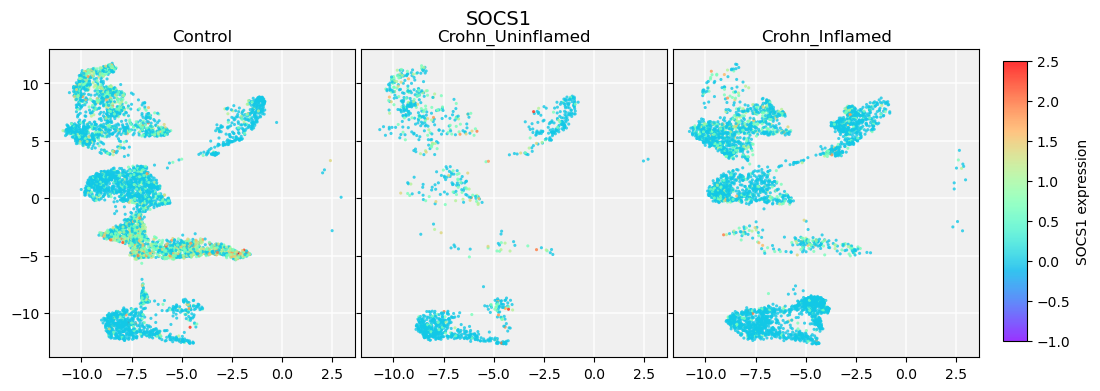

In [128]:
# Example usage:
fig = plot_gene_expression_by_state(
    immun_adata,
    gene_id='SOCS1',
    state_key='inferred state',
    figsize=4,
    s=5,
    cmap='rainbow',
    log_transform=True,
    state_order=['Control', 'Crohn_Uninflamed', 'Crohn_Inflamed'],
    vmin = -1,
    vmax= 2.5
)
plt.show()

# Test Plot

In [96]:
def plot_umap_numbered(
    adata,
    annotation_key='annotation_V2',
    palette="tab20",  # Changed default to tab20 which has more distinct colors
    figsize=9,
    s=15,
    bg_color='#f0f0f0',
    fontsize=10,
    title_fontsize=12,
    title=None,
    number_clusters=True,
    text_size=10,
    text_color='black',
    text_weight='bold',
    text_bg_alpha=0.7,
    text_bg_color='white',
    custom_order=None
):
    """
    Plot UMAP visualization of single-cell data with numbered clusters.
    
    Parameters
    ----------
    adata : AnnData
        AnnData object containing UMAP coordinates in .obsm['X_umap']
    annotation_key : str, default='annotation_V2'
        Key in adata.obs for cell annotations/clusters
    palette : str or list, default='tab20'
        Color palette name or list of colors
    figsize : int, default=9
        Size of the square figure
    s : int, default=15
        Size of scatter points
    bg_color : str, default='#f0f0f0'
        Background color of the plot
    fontsize : int, default=10
        Font size for legend text
    title_fontsize : int, default=12
        Font size for legend title and plot title
    title : str, optional
        Title for the plot. If None, uses "UMAP of [annotation_key]"
    number_clusters : bool, default=True
        Whether to add numeric labels to clusters and legend
    text_size : int, default=10
        Size of the numeric labels on the plot
    text_color : str, default='black'
        Color of the numeric labels
    text_weight : str, default='bold'
        Font weight for numeric labels
    text_bg_alpha : float, default=0.7
        Alpha transparency for text background
    text_bg_color : str, default='white'
        Background color for text labels
    custom_order : list, optional
        Optional list specifying the order of categories. If provided, 
        this order will be used instead of alphabetical.
        
    Returns
    -------
    matplotlib.figure.Figure, matplotlib.axes.Axes
        Figure and axes objects for further customization
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import pandas as pd
    import seaborn as sns
    import numpy as np
    from matplotlib.patheffects import withStroke
    
    # Extract UMAP coordinates and annotations
    umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'])
    umap_df[annotation_key] = adata.obs[annotation_key].values
    
    # Get unique categories
    if custom_order is not None:
        # Verify all categories are present in custom_order
        all_cats = set(umap_df[annotation_key].unique())
        if not all_cats.issubset(set(custom_order)):
            missing = all_cats - set(custom_order)
            raise ValueError(f"Custom order missing categories: {missing}")
        categories = custom_order
    else:
        categories = sorted(umap_df[annotation_key].unique())
    
    # Create color mapping
    num_categories = len(categories)
    
    # Get a color palette with enough colors
    if isinstance(palette, str):
        # If palette is a name, create a color list
        colors = sns.color_palette(palette, num_categories)
    else:
        # If palette is already a list of colors, use it directly
        colors = palette
        # Ensure we have enough colors
        if len(colors) < num_categories:
            # Extend palette if needed
            colors = colors * (num_categories // len(colors) + 1)
            colors = colors[:num_categories]
    
    # Create mapping between categories and colors
    color_dict = {cat: colors[i] for i, cat in enumerate(categories)}
    
    # Create figure
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    
    # Set background color
    ax.set_facecolor(bg_color)
    
    # Ensure grid is below the scatterplot
    ax.set_axisbelow(True)
    ax.grid(True, color='white', linewidth=2, alpha=0.7)
    
    # Plot each category with its assigned color
    for cat in categories:
        mask = umap_df[annotation_key] == cat
        if mask.sum() > 0:
            ax.scatter(
                umap_df.loc[mask, 'UMAP1'], 
                umap_df.loc[mask, 'UMAP2'],
                color=color_dict[cat],
                s=s,
                alpha=0.8,
                linewidth=0,
                label=cat
            )
    
    # Create numbered legend items with correct colors
    handles = []
    for i, cat in enumerate(categories):
        number = i + 1
        patch = mpatches.Patch(color=color_dict[cat], label=f"{number}. {cat}")
        handles.append(patch)
    
    # Add legend
    ax.legend(
        handles=handles,
        title=annotation_key,
        fontsize=fontsize,
        title_fontsize=title_fontsize,
        loc='best',
        frameon=True,
        fancybox=True,
        framealpha=0.8,
        handleheight=1.5,
        handlelength=1.5
    )
    
    # Add title
    if title:
        ax.set_title(title, fontsize=title_fontsize)
    else:
        ax.set_title(f"UMAP of {annotation_key}", fontsize=title_fontsize)
    
    # Add cluster numbers to the plot
    if number_clusters:
        for i, cat in enumerate(categories):
            mask = umap_df[annotation_key] == cat
            if mask.sum() > 0:
                # Calculate centroid
                x = umap_df.loc[mask, 'UMAP1'].median()
                y = umap_df.loc[mask, 'UMAP2'].median()
                
                # Add cluster number
                txt = ax.text(
                    x, y, 
                    str(i+1), 
                    fontsize=text_size,
                    fontweight=text_weight,
                    ha='center', 
                    va='center',
                    color=text_color,
                    bbox=dict(
                        boxstyle="circle,pad=0.3", 
                        fc=text_bg_color, 
                        ec="none", 
                        alpha=text_bg_alpha
                    )
                )
                txt.set_path_effects([withStroke(linewidth=3, foreground=text_bg_color)])
    
    # Adjust labels
    ax.set_xlabel('UMAP1', fontsize=fontsize)
    ax.set_ylabel('UMAP2', fontsize=fontsize)
    
    plt.tight_layout()
    return fig, ax

# Example usage:
# fig, ax = plot_umap_numbered(
#     adata,
#     annotation_key='annotation_V2',
#     palette='tab20',  # More distinct colors
#     figsize=10,
#     s=15,
#     text_size=12,
#     title='UMAP of Immune Cells with Numbered Clusters'
# )
# plt.show()

/tmp/ipykernel_6145/3286705891.py:118: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(


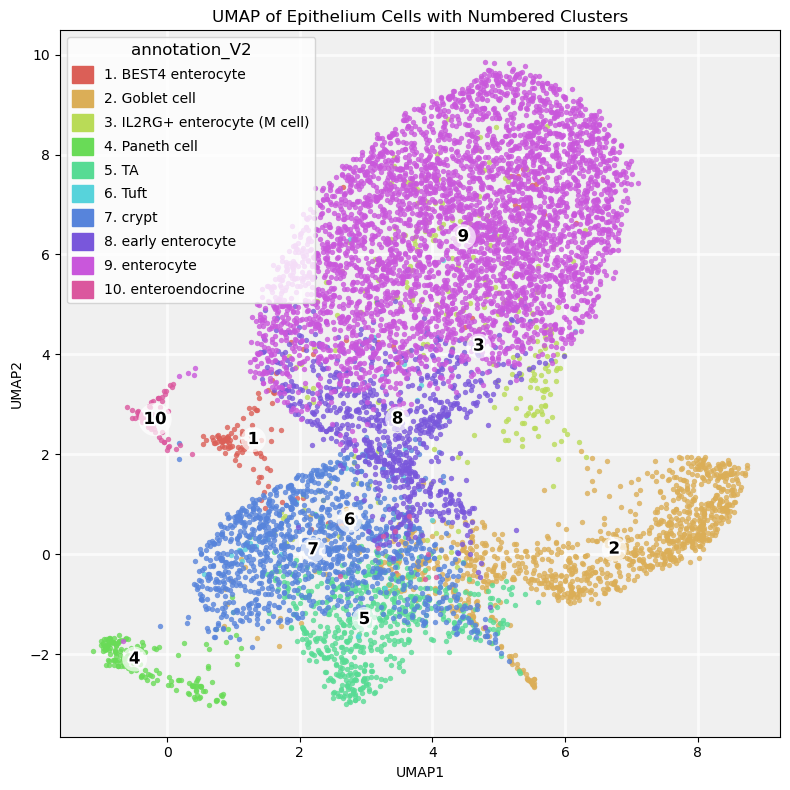

In [95]:
# Example usage:
fig, ax = plot_umap_numbered(
    epith_adata,
    annotation_key='annotation_V2',
    palette='hls',  # More distinct colors
    figsize=8,
    s=15,
    text_size=12,
    title='UMAP of Epithelium Cells with Numbered Clusters'
)
plt.show()